# Orchestrator notebook for AI Bubble Analysis

In [19]:
import os
import sys
from datetime import datetime
import pandas as pd
import importlib

ai_bubble_research = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research"
if ai_bubble_research not in sys.path:
    sys.path.insert(0, ai_bubble_research)

In [20]:
modules_to_reload = [
    'Data_analysis.src.analysis.returns',
    'Data_analysis.src.analysis.valuations',
    'Data_analysis.src.analysis.fundamentals',
    'Data_analysis.src.analysis.links',
    'Data_analysis.src.analysis.risk',
    'Data_analysis.src.analysis',
    'Data_analysis.src.data_prep',
    'Data_analysis.src',
    'Data_analysis',
]

for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        try:
            importlib.reload(sys.modules[mod_name])
        except Exception as e:
            print(f"Note: Could not reload {mod_name}: {e}")

from Data_analysis.src.data_prep import build_and_save_panel
from Data_analysis.src.analysis.returns import build_group_indices, plot_group_indices
from Data_analysis.src.analysis.valuations import _prep_latest, make_long_valuations, plot_valuation_boxplots
from Data_analysis.src.analysis.fundamentals import make_long_fundamentals, plot_fundamentals_boxplots
from Data_analysis.src.analysis.links import plot_link_scatter_panels
from Data_analysis.src.analysis.risk import plot_debt_equity_distribution, plot_unprofitable_shares

Paths

In [21]:
DATA_DIR = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research/Data_preparation/datasets/final_data"
GROUP_MAP_CSV = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research/Data_analysis/mappings/group_map.csv"
PANEL_PARQUET = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research/Data_analysis/data/processed/panel.parquet"
FIG_DIR = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research/Data_analysis/reports/figures"
TAB_DIR = "/Users/k./Documents/projects/AI_Bubble/ai-bubble-research/Data_analysis/reports/tables"

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# Build panel and save
panel, latest = build_and_save_panel(DATA_DIR, GROUP_MAP_CSV, PANEL_PARQUET)
print(panel.shape, latest.shape)

(5543, 42) (118, 42)


Analysis 1: Price performance (indexed returns)

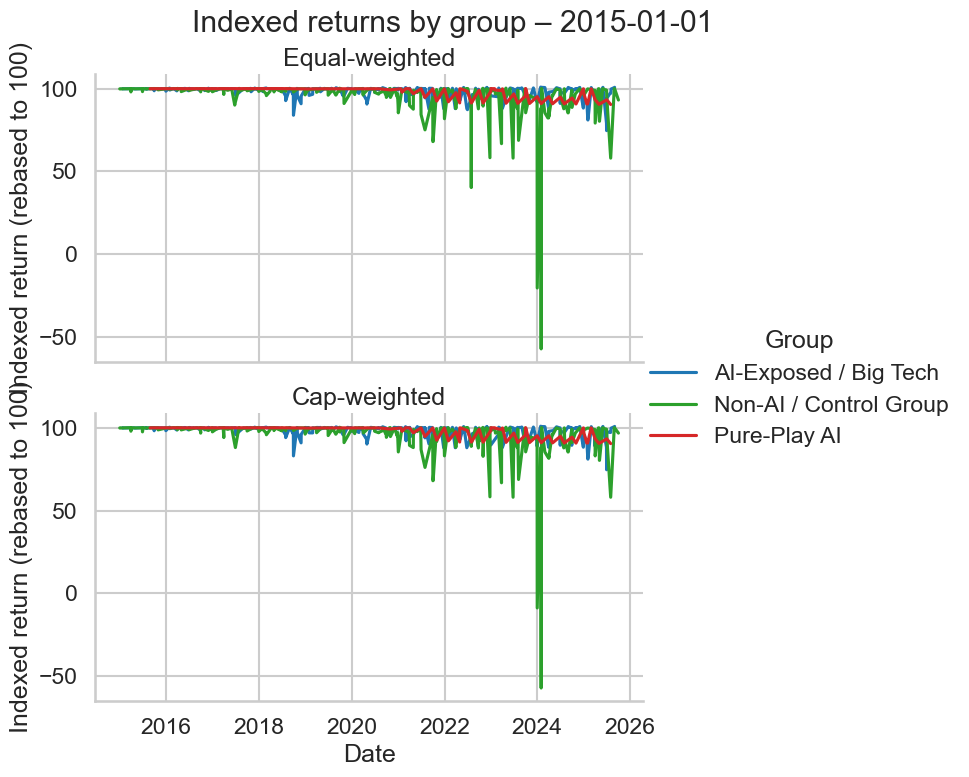


Latest indexed returns (as of 2015-01-01):
Equal-weighted: {'AI-Exposed / Big Tech': 100.8857355242269, 'Non-AI / Control Group': 93.20248627702544, 'Pure-Play AI': 90.49671390489922}
Cap-weighted: {'AI-Exposed / Big Tech': 100.8857355242269, 'Non-AI / Control Group': 96.85097610517406, 'Pure-Play AI': 90.49671390489922}


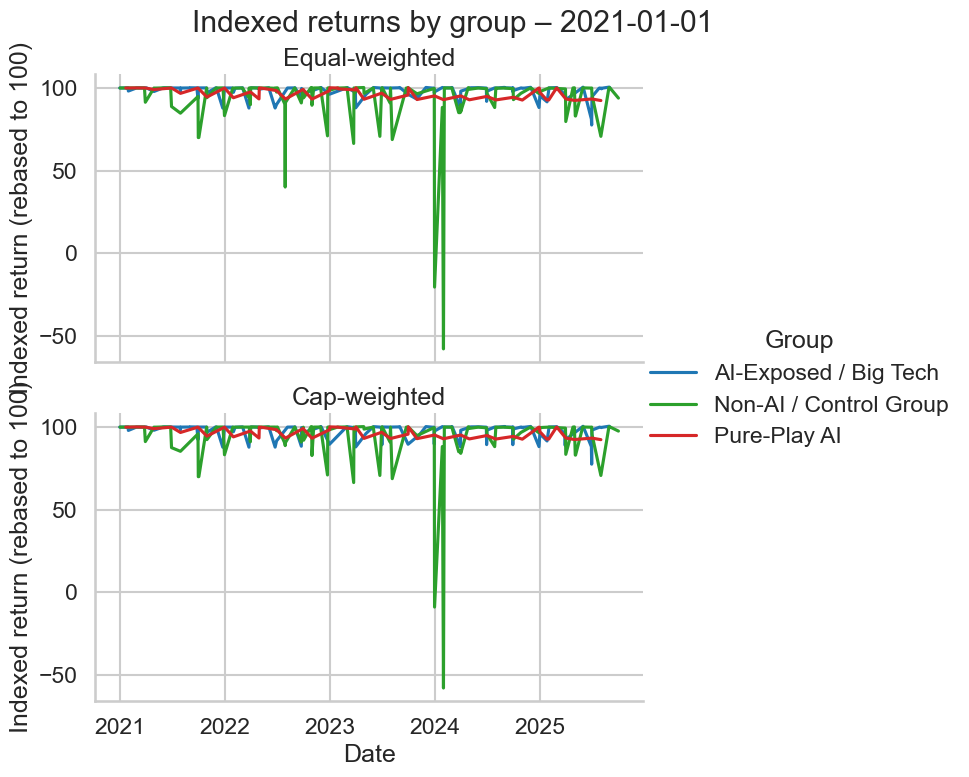


Latest indexed returns (as of 2021-01-01):
Equal-weighted: {'AI-Exposed / Big Tech': 100.16419048348135, 'Non-AI / Control Group': 93.88266507104635, 'Pure-Play AI': 92.40647797353726}
Cap-weighted: {'AI-Exposed / Big Tech': 100.16419048348135, 'Non-AI / Control Group': 97.59113525936019, 'Pure-Play AI': 92.40647797353726}


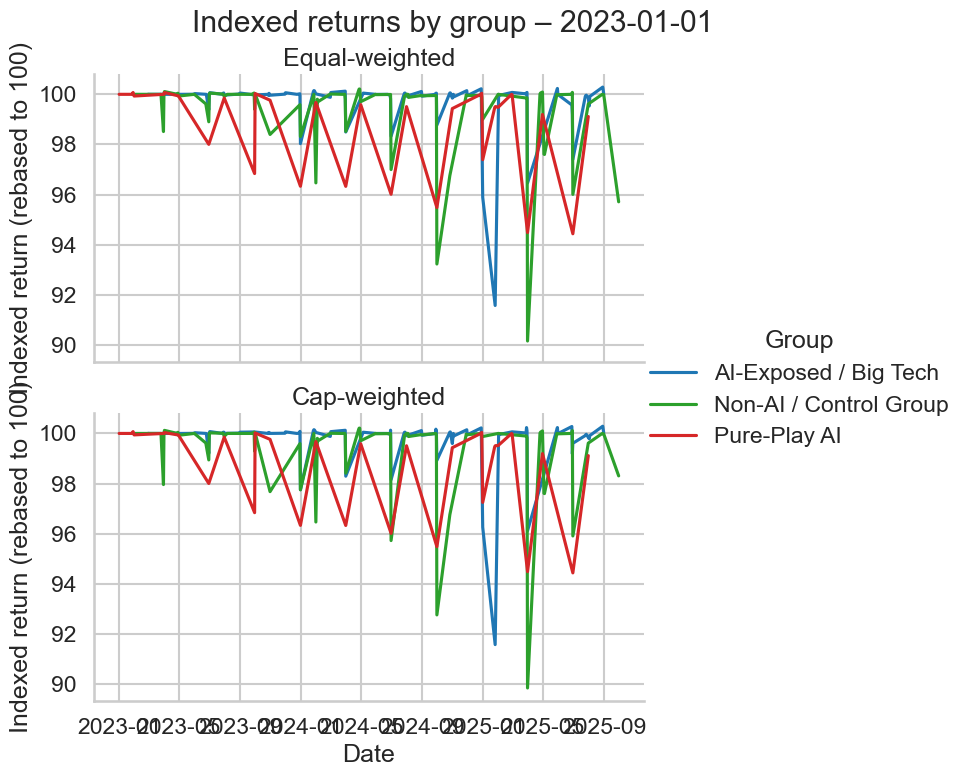


Latest indexed returns (as of 2023-01-01):
Equal-weighted: {'AI-Exposed / Big Tech': 100.02146917617185, 'Pure-Play AI': 99.11471956421586, 'Non-AI / Control Group': 95.71242000549819}
Cap-weighted: {'AI-Exposed / Big Tech': 100.02146917617185, 'Pure-Play AI': 99.11471956421586, 'Non-AI / Control Group': 98.30749350094877}


In [22]:
for start in ["2015-01-01", "2021-01-01", "2023-01-01"]:
    eq, cap = build_group_indices(panel, start_date=start)
    outpath = os.path.join(FIG_DIR, f"indexed_returns_{start}.png")
    plot_group_indices(eq, cap, outpath=outpath, title_suffix=start)

    # Save the aggregated time series for reference
    eq.assign(start=start).to_csv(os.path.join(TAB_DIR, f"indexed_eq_{start}.csv"), index=False)
    cap.assign(start=start).to_csv(os.path.join(TAB_DIR, f"indexed_cap_{start}.csv"), index=False)
    
    # Display latest values in notebook
    print(f"\nLatest indexed returns (as of {start}):")
    latest_eq = eq.groupby("group")["group_index"].last().sort_values(ascending=False)
    latest_cap_vals = cap.groupby("group")["group_index"].last().sort_values(ascending=False)
    print("Equal-weighted:", latest_eq.to_dict())
    print("Cap-weighted:", latest_cap_vals.to_dict())


Analysis 2: Valuation multiples (box plots)

Valuation metrics summary by group:
                                    count       mean         std         min  \
group                  metric                                                  
AI-Exposed / Big Tech  P/FCF Ratio   47.0  36.636819  115.875570 -502.678168   
                       PE Ratio      26.0  19.751491  154.003278 -609.063000   
                       PEG           20.0   1.622442    8.531148  -13.521715   
                       PS Ratio      47.0   6.421534    5.286207    0.410060   
Non-AI / Control Group P/FCF Ratio   64.0  36.590669  123.020264 -502.678168   
                       PE Ratio      35.0  33.706788  142.381658 -686.647600   
                       PEG           28.0   2.694746   11.649663   -7.744447   
                       PS Ratio      64.0   4.987268    4.134790    0.410060   
Pure-Play AI           P/FCF Ratio    7.0  51.689414   99.251947  -36.875953   
                       PE Ratio       2.0  32.432000    4.894593   28.971000   
    

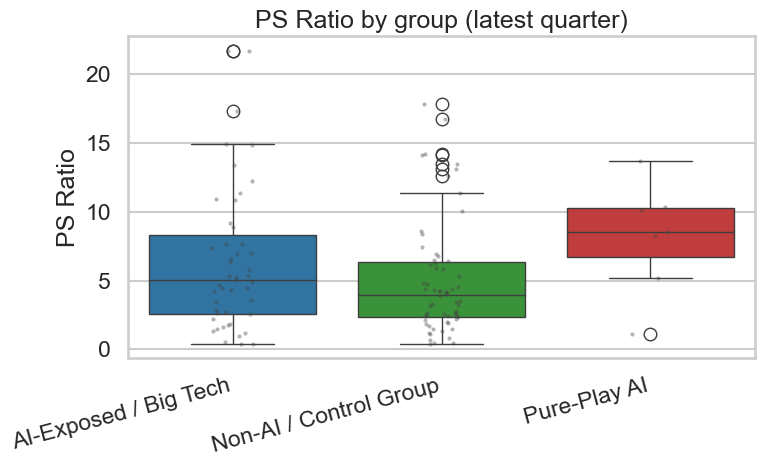

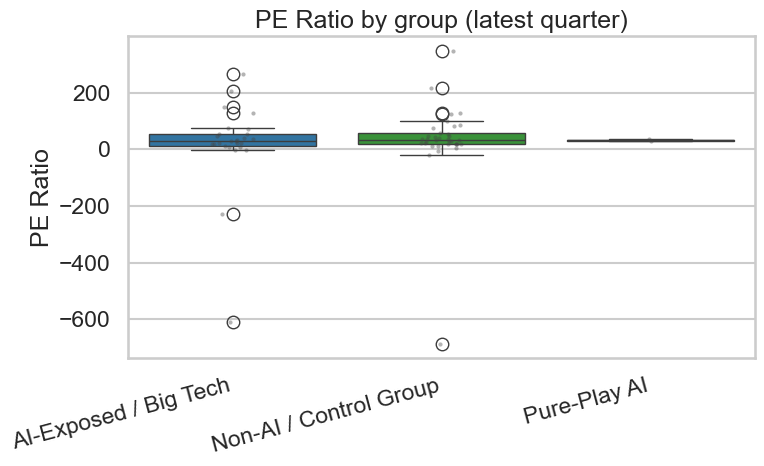

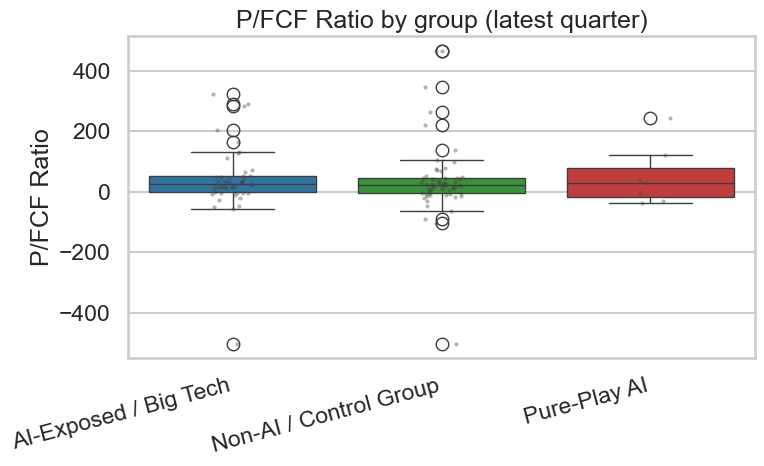

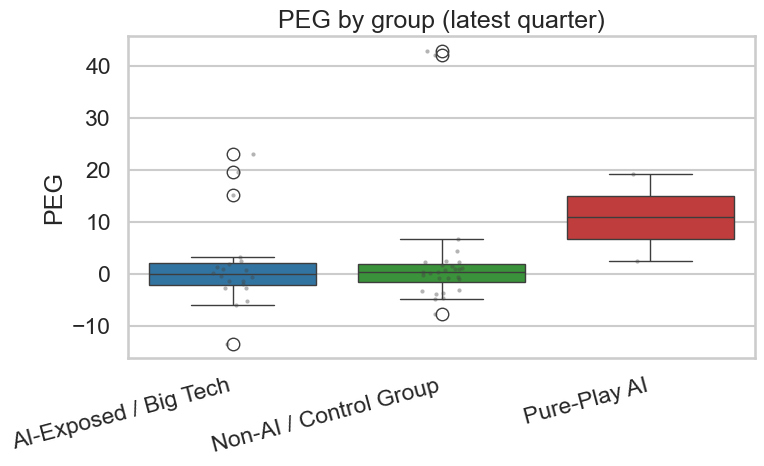

In [23]:
latest_cs = _prep_latest(panel)
val_long = make_long_valuations(latest_cs, winsorize=True)
val_long.to_csv(os.path.join(TAB_DIR, "valuations_long_latest.csv"), index=False)
# Display summary statistics
print("Valuation metrics summary by group:")
print(val_long.groupby(["group", "metric"])["value"].describe())
plot_valuation_boxplots(val_long, FIG_DIR)



Analysis 3: Fundamentals (growth, margins, R&D)

Fundamentals summary by group:
                                                count      mean       std  \
group                  metric                                               
AI-Exposed / Big Tech  EPS Growth                20.0  0.567075  2.209573   
                       Free Cash Flow Margin_y   47.0  0.052629  0.262539   
                       Operating Margin          47.0  0.001808  0.302872   
                       R&D_pct_of_Revenue        47.0  0.234676  0.239506   
                       Revenue Growth            46.0  0.149237  0.425707   
Non-AI / Control Group EPS Growth                28.0  0.826138  2.750699   
                       Free Cash Flow Margin_y   64.0  0.017718  0.272216   
                       Operating Margin          64.0  0.023458  0.218155   
                       R&D_pct_of_Revenue        64.0  0.173405  0.169659   
                       Revenue Growth            64.0  0.118029  0.265976   
Pure-Play AI           EPS Growth            

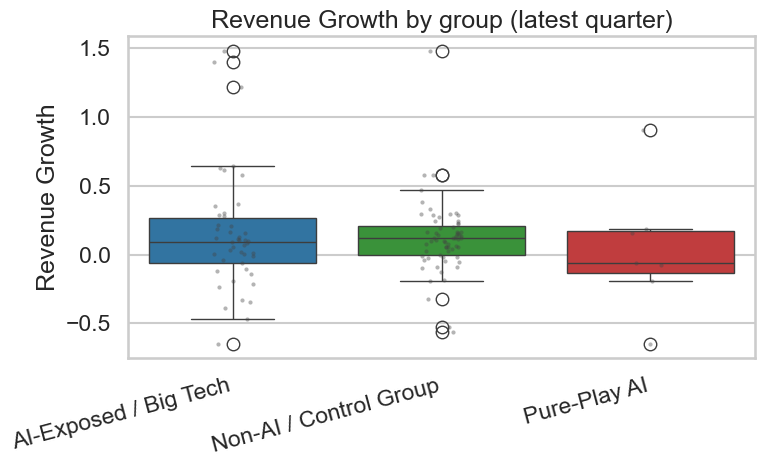

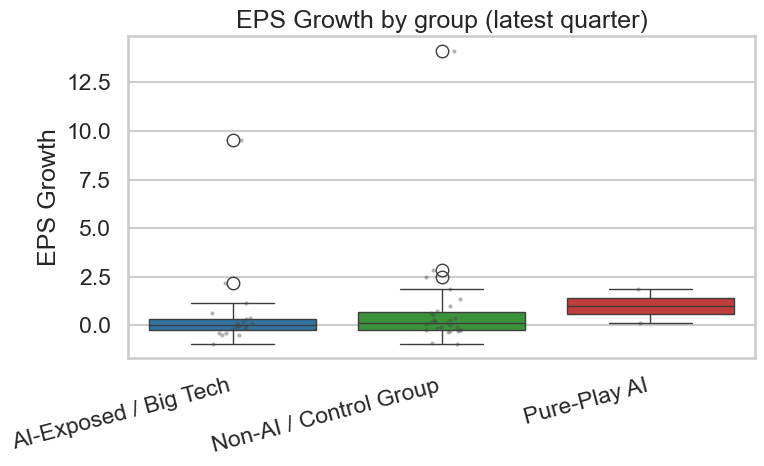

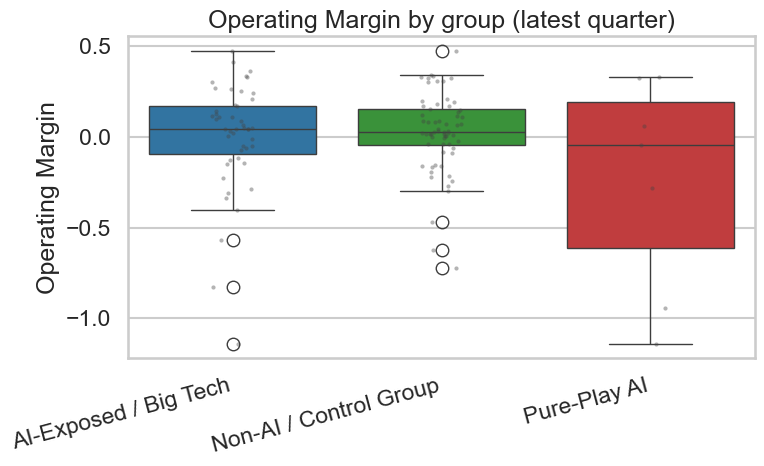

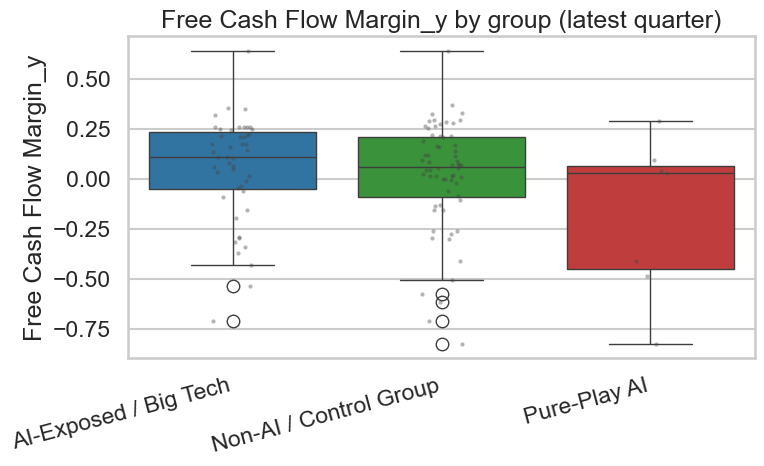

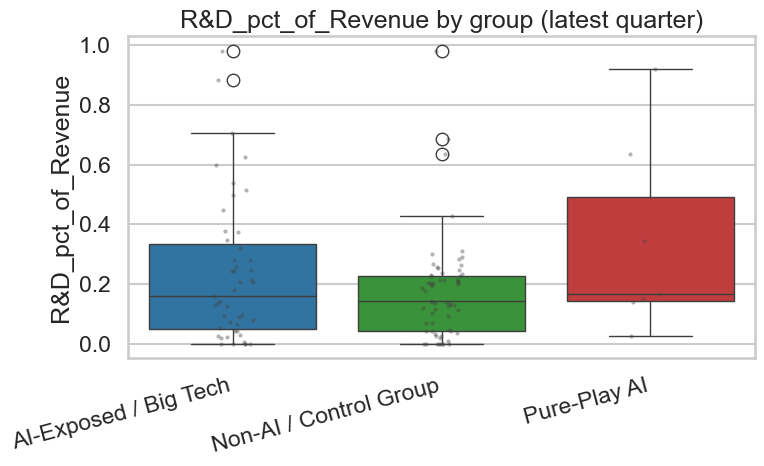

In [24]:
fund_long = make_long_fundamentals(panel, winsorize=True)
fund_long.to_csv(os.path.join(TAB_DIR, "fundamentals_long_latest.csv"), index=False)
# Display summary statistics
print("Fundamentals summary by group:")
print(fund_long.groupby(["group", "metric"])["value"].describe())
plot_fundamentals_boxplots(fund_long, FIG_DIR)

Analysis 4: Linking valuation to fundamentals (scatters)

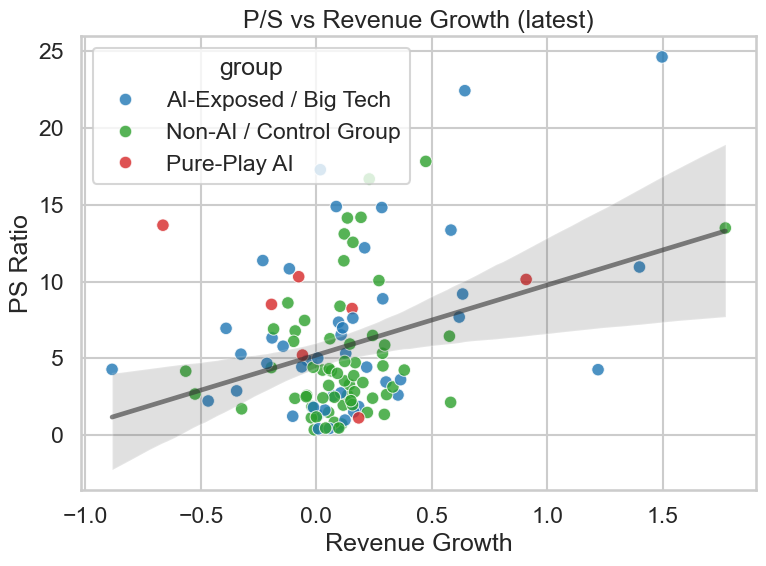

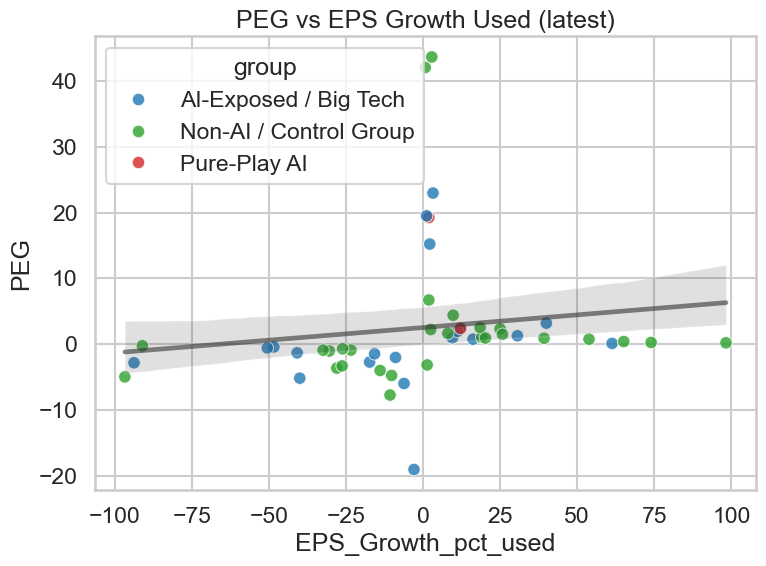

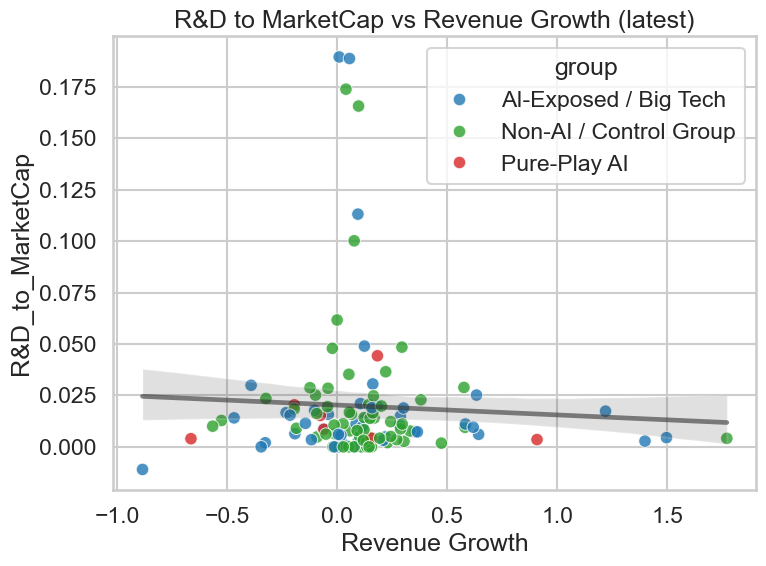

In [25]:
plot_link_scatter_panels(panel, FIG_DIR)

Analysis 5: Risk profiles

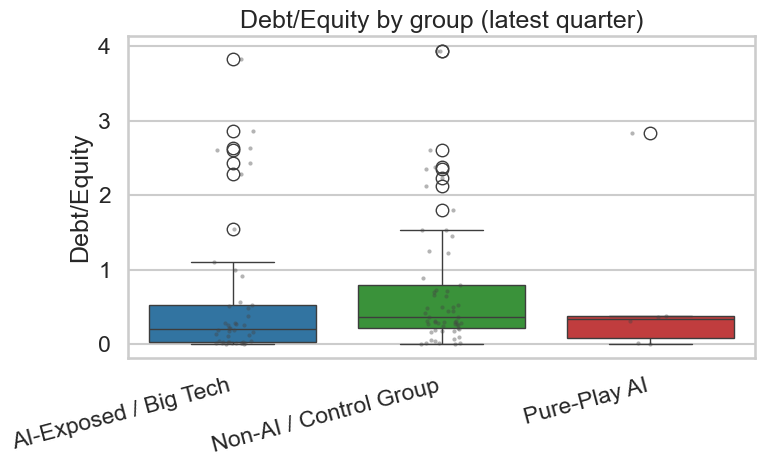

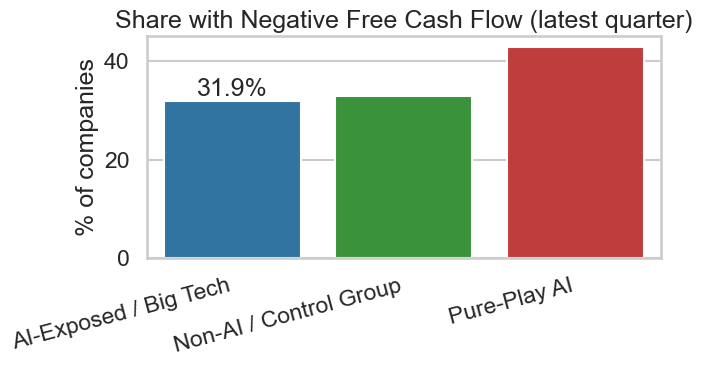

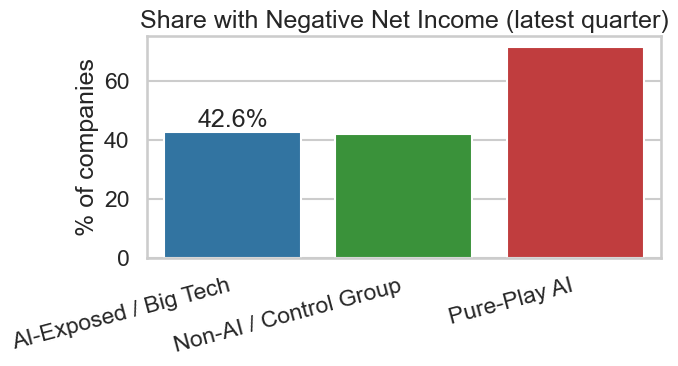

In [26]:
plot_debt_equity_distribution(panel, os.path.join(FIG_DIR, "risk_debt_equity.png"))
plot_unprofitable_shares(panel, os.path.join(FIG_DIR, "risk_share_negative"))

Cohort sensitivity: age-stratified medians (latest quarter)

In [27]:
latest_cs = latest_cs.copy()
first_dates = panel.groupby("fixed_ticker")["Date"].min().rename("first_date")
latest_cs = latest_cs.merge(first_dates, on="fixed_ticker", how="left")
latest_cs["age_years"] = (latest_cs["Date"] - latest_cs["first_date"]).dt.days / 365.25
bins = [0, 3, 6, 100]
labels = ["0-3y", "3-6y", ">6y"]
latest_cs["age_bin"] = pd.cut(latest_cs["age_years"], bins=bins, labels=labels, right=False)

median_table = (
    latest_cs
      .assign(
          ps=pd.to_numeric(latest_cs["PS Ratio"], errors="coerce"),
          pe=pd.to_numeric(latest_cs["PE Ratio"], errors="coerce"),
          pfcf=pd.to_numeric(latest_cs["P/FCF Ratio"], errors="coerce"),
          peg=pd.to_numeric(latest_cs["PEG"], errors="coerce"),
          revg=pd.to_numeric(latest_cs["Revenue Growth"], errors="coerce"),
          opm=pd.to_numeric(latest_cs["Operating Margin"], errors="coerce"),
      )
      .groupby(["group", "age_bin"], observed=True) [ ["ps","pe","pfcf","peg","revg","opm"] ]
      .median()
      .reset_index()
)
median_table.to_csv(os.path.join(TAB_DIR, "age_stratified_medians_latest.csv"), index=False)
# Display the full table in the notebook
from IPython.display import display
display(median_table)


,group,age_bin,ps,pe,pfcf,peg,revg,opm
0,AI-Exposed / Big Tech,0-3y,7.6150,39.126000,44.984007,-0.949597,0.086170,0.050630
1,AI-Exposed / Big Tech,3-6y,4.8630,48.243500,32.430494,3.199700,0.061575,-0.013140
2,AI-Exposed / Big Tech,>6y,4.2590,21.750000,15.763323,-0.421681,0.096280,0.062710
3,Non-AI / Control Group,0-3y,3.5270,22.358000,19.931924,0.578030,0.064780,-0.009040
4,Non-AI / Control Group,3-6y,4.4590,53.487000,24.256842,1.913942,0.165080,0.080135
5,Non-AI / Control Group,>6y,3.4200,35.288075,21.915907,-0.972807,0.116590,0.032570
6,Pure-Play AI,0-3y,6.7240,28.971000,79.724341,2.390149,0.047375,0.009200
7,Pure-Play AI,3-6y,13.6670,NaN,-29.886290,NaN,-0.664600,-0.941770
8,Pure-Play AI,>6y,9.3215,35.893000,-3.430149,19.284145,0.357180,-0.724825
